In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

### Helpers

In [2]:
def train_valid_test_split(X, y, val_size=.2, test_size=.2, shuffle=False):
    if val_size < 0 or test_size < 0:
        
        raise EnvironmentError("validation or test size should not be negative!")
    
    if val_size + test_size >= 1.:
        raise EnvironmentError("validation + test size should be lesser than 1!")
    
    x_data, y_data = X, y
    if shuffle:
        for _ in range(3):
            temp = list(zip(x_data.T, y_data.T))
            random.shuffle(temp)
            x_data, y_data = zip(*temp)
            x_data = np.array(list(x_data)).T
            y_data = np.array(list(y_data)).T
        
    
    val_indx = int(val_size * x_data.shape[1])
    test_indx = int(test_size * x_data.shape[1])
    X_val, X_test, X_train = x_data[:, :val_indx], x_data[:, val_indx:val_indx+test_indx], x_data[:, val_indx+test_indx:]
    y_val, y_test, y_train = y_data[:, :val_indx], y_data[:, val_indx:val_indx+test_indx], y_data[:, val_indx+test_indx:]
    
    return X_train, X_test, X_val, y_train, y_test, y_val

def accuracy(y_pred, y_true):

    return 100. * sum(np.argmax(y_pred, axis=0) == np.argmax(y_true, axis=0)) / y_true.shape[1]

### Activation Functions

In [3]:
# rectified linear unit
def ReLU(x):
    x = np.where(x < 0, 0, x)
    return x
# derivative of ReLU
def dReLU(x):
    x = np.where(x < 0, 0, x)
    x = np.where(x > 0, 1, x)
    return x

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1. - tanh(x)**2

# sigmoid function
def sigm(x):
    return 1. / (1. + np.exp(-x))

# derivative of sigmoid function
def dsigm(x):
    z = sigm(x)
    return z * (1. - z)
def softmax(x):
    x = x - np.max(x, axis=0, keepdims=True)
    exp_x = np.exp(x)
    exp_x /= np.sum(exp_x, axis=0, keepdims=True)
    return exp_x
def dsoftmax(y_hat, y):
    return y_hat - y

### Loading Data

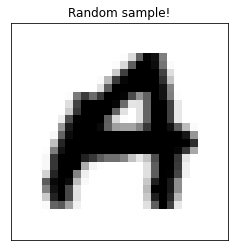

In [4]:
data_train = pd.read_csv("data/data.csv", index_col=0)
m= data_train.shape[0]

x = np.array(data_train.drop(columns=["class"])).T /256.
y = np.zeros((26, m))

for i in range(m):
    ind = data_train.iloc[i]["class"]
    y[ind, i] = 1.

plt.figure(figsize=(4, 4))
plt.imshow(x[:, random.randint(0, m-1)].reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys)
plt.xticks([])
plt.yticks([])
plt.title("Random sample!")
plt.show()

The data that will be used is consisted of 26000 images of shape $28 \times 28$ pixels, 1000 samples for each character. The corresponding label for a given input $x^{(i)}$ is $y^{(i)}$ with shape $26 \times 1$:

$$y^{(i)} =
\begin{pmatrix}
 0 \\ 0 \\ \vdots \\ 1 \\ \vdots \\ 0
\end{pmatrix}_{26 \times 1}, \ \ \ y_k^{(i)} = 1, \ \ \ 0 \le k \le 25
$$

where the number $k$ denotes that the given input $x^{(i)}$ is an image of the $(k+1)^{th}$ character in the alphabet. As an example, if $k = 2$, then the input is an image of character `C`.

We'll be using 26 perceptrons with 784 entries as our model to train. Let $z = Wx + b$. The activation function for this model will be _Linear_, meaning $\hat{y} = z$.

### Loss Function

We need a loss function to minimize and use it for finding the optimal weights and the optimal bias:
$$\mathscr{L} = -y\hat{y}$$
In which $y$ is the correct class for given input $x$.

Although, this loss function is linear, meaning it can always get smaller, but beyond a certain point, the desired results will imporve no more.

### Optimization

For optimization, we'll take the steps below:
$$\begin{align}
\frac{\partial\mathscr{L}}{\partial W} &= \frac{\partial\mathscr{L}}{\partial \hat{y}} \cdot \frac{\partial\hat{y}}{\partial z} \cdot \frac{\partial z}{\partial W} = -y \cdot 1 \cdot x^T \\\\
\frac{\partial\mathscr{L}}{\partial b} &= \frac{\partial\mathscr{L}}{\partial \hat{y}} \cdot \frac{\partial\hat{y}}{\partial z} \cdot \frac{\partial z}{\partial b} = -y \cdot 1 \cdot 1 \\\\
W &= W - \alpha \frac{\partial\mathscr{L}}{\partial W} \\
b &= b - \alpha \frac{\partial\mathscr{L}}{\partial b}\\
(\alpha \ &\text{is the learning rate})
\end{align}$$

In [5]:
def loss(y_hat, y):
    return np.mean(-y*y_hat, axis=1)[0]

def dloss(y_hat, y):
    # derivative of Loss with respect to z
    return -y

def softmax_cross_entropy_cost(y_hat, y):
    cost = np.mean(-np.sum(y * np.log(y_hat+1e-9), axis=0))
    return cost

def dsoftmax_cross_entropy_cost(y_hat, y):
    # derivative of softmax_cross_entropy_cost with respect to z
    return y_hat - y

### Preprocessing Data

In [6]:
X_train, X_test, X_val, y_train, y_test, y_val = train_valid_test_split(x, y, test_size=.2, val_size=.2, shuffle=True)
# mean value of features
mu = np.mean(X_train, axis=1, keepdims=True)

# remove mean vector from all data
X_train -= mu
X_val -= mu
X_test  -= mu

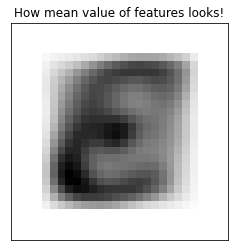

In [7]:
plt.figure(figsize=(4, 4))
plt.imshow(mu.reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys)
plt.xticks([])
plt.yticks([])
plt.title("How mean value of features looks!")
plt.show()

The benefit of subtracting the `mu` value from the data is that the probability of overfitting gets much lesser and we'll get much better accuracy from the model.

This is the model that we'll use without subtracting the `mu` value:

<img src="imgs/sameModel.png" height="75%" width="100%">

And this is how the weights will look like after training:

<img src="imgs/overfit.png" height="75%" width="100%">

Looks good, but the accuracy of the model with these weights is not promising:

<img src="imgs/lessAcc.png" height="50%" width="75%">

The results of subtracting `mu` is shown in the code below.

In [8]:
# the following class, allows us to create layers with varying neuron counts
class Layer:
    
    def __init__(self, in_shape, n_neurons, Activation="ReLU"):
        if in_shape <= 0 or n_neurons <= 0:
            raise EnvironmentError("Input values should be positive!")
        
        self.shape = np.array([n_neurons, in_shape])
        self.b = np.zeros((self.shape[0], 1)) # the biases
        
        # Initializing Wieghts and specifying activation function for the layer
        if Activation == "ReLU":
            self.Activation = ReLU
            self.dActivation = dReLU
            self.W = np.random.randn(*self.shape) * np.sqrt(2. / self.shape[1])
        elif Activation == "sigm":
            self.Activation = sigm
            self.dActivation = dsigm
            self.W = np.random.randn(*self.shape) * np.sqrt(1. / self.shape[1])
        elif Activation == "tanh":
            self.Activation = tanh
            self.dActivation = dtanh
            self.W = np.random.randn(*self.shape) * np.sqrt(1. / sum(self.shape))
        elif Activation == "Linear":
            self.Activation = lambda x: x
            self.dActivation = lambda x: np.ones_like(x)
            self.W = np.zeros(self.shape)
        elif Activation == "soft":
            self.Activation = softmax
            self.dActivation = dsoftmax
            self.W = np.random.randn(*self.shape) * 0.001
        else:
            raise EnvironmentError("Activation function not defined!")
            
        self.x = None # the given input to the Layer        
        self.z = None # the result from the linear part (Wx + b)
        self.a = None # the result from the activation part (activation(z))
        
    def train(self, x):
        self.x = x
        self.z = self.W @ self.x + self.b # computing the linear part
        self.a = self.Activation(self.z) # computing the activation part

In [9]:
# with the help of the following class we can create a Neural Network model with multiple and different layers,
# choose a specific lost function to train the model based on it, define desirable learning rate, set the number
# of training iterations, and set favourable batch sizes.
class NeuralNetwork:
    def __init__(self, Layers, cost, dcost, early_stopping=5, num_iterations=100, alpha=.05):
        self.num_iterations = num_iterations # iteration count
        self.alpha = alpha # the learning rate
            
        if type(Layers) == list:
            for layer in Layers:
                if not isinstance(layer, Layer):
                    raise EnvironmentError("All inputs should be of type 'Layer'")
        else:
            raise EnvironmentError("Wrong input for Layers!")
        
        for i in range(len(Layers)-1):
            if Layers[i].shape[0] != Layers[i+1].shape[1]:
                raise EnvironmentError(f"The input size for Layer {i+2} should be " + \
                                       f"the same as the neurons count in Layer {i+1}!")
            
       
        self.cost = cost
        self.dcost = dcost
                
        self.Layers = Layers # The Layers in the neural net
        self.X_train = None # data that the model will be trained with
        self.y_hat, self.y_train = None, None # predictions, correct classes
        self.J = [] # train losses
        self.val_J = [] # validation losses
        self.early_stopping = early_stopping
        
    def fit(self, X_train, y_train, X_val, y_val, batch_size=32):
        if X_train.shape[0] != self.Layers[0].shape[1]:
            raise EnvironmentError(f"X_train should be of shape ({self.Layers[0].shape[0]}, N)")
        
        if y_train.shape[0] != self.Layers[-1].shape[0]:
            raise EnvironmentError(f"y_train sholud be of shape({self.Layers[-1].shape[0]}, N)")
            
        if X_val.shape[0] != self.Layers[0].shape[1]:
            raise EnvironmentError(f"X_val should be of shape ({self.Layers[0].shape[0]}, N)")
        
        if y_val.shape[0] != self.Layers[-1].shape[0]:
            raise EnvironmentError(f"y_val sholud be of shape({self.Layers[-1].shape[0]}, N)")
            
            
        
            
        self.X_train = X_train
        self.y_train = y_train
        
        m = X_train.shape[1] # number of inputs
        num_batches = m // batch_size
        
        report = "Iteration {:3d}: training loss = {:.2f} | validation loss = {:.2f}"
        c, epsilon = 0, 1e-3
        
        for iteration in range(self.num_iterations):
            train_loss = 0.
        
            for batch in range(num_batches):

                # select a random mini-batch
                idx = np.random.choice(m, batch_size, replace=False)
                X_batch, y_batch = self.X_train[:, idx], self.y_train[:, idx]
                
                self.y_hat = self.predict(X_batch)
                train_loss += self.cost(self.y_hat, y_batch)
                self.update(X_batch, y_batch)

            # report stats after each epoch
            train_loss /= num_batches        
            valid_loss = self.cost(self.predict(X_val), y_val)
            
            self.J.append(train_loss)
            self.val_J.append(valid_loss)
            print(report.format(iteration+1, train_loss, valid_loss))
            
            if self.early_stopping != 0 and iteration >= 2:
                if np.abs(self.J[-2] - self.J[-1]) < epsilon:
                    c += 1
                    if c == self.early_stopping:
                        print("Training finished early due to early stopping!")
                        break
                else:
                    c = 0
        
    # update function: optimizing to achieve optimal values for wieghts and biases          
    def update(self, X_batch, y_batch):

        size = X_batch.shape[1]
        derivatives = []
        # derivative of loss with respect to the result of the linear part in the networks last layer (z^n)
        dJ = self.dcost(self.y_hat, y_batch) 
        derivatives.append(dJ / size)

        for i in range(len(self.Layers) - 2, -1, -1):
            # derivative of loss with respect to the result of the linear part in the ith layer
            # in order to have the right shape, we take the dot product of W^T with dl/dz^(i+1)
            # and multiply it (elementwise) with the result of this layers' activation part
            derivative = (self.Layers[i+1].W.T @ derivatives[-1]) * self.Layers[i].dActivation(self.Layers[i].z)
            derivatives.append(derivative)
            
        derivatives.reverse()

        # computing for every dl/dW^i and dl/db^i
        for i in range(len(self.Layers) - 1, 0, -1):
            self.Layers[i].W -= self.alpha *  derivatives[i] @ self.Layers[i-1].a.T
            self.Layers[i].b -= self.alpha * np.sum(derivatives[i], axis=1, keepdims=True)
        self.Layers[0].W -= self.alpha * derivatives[0] @ X_batch.T
        self.Layers[0].b -= self.alpha * np.sum(derivatives[0], axis=1, keepdims=True)
            
    
    def predict(self, X):
        for i in range(len(self.Layers)):
            self.Layers[i].train(X)
            X = self.Layers[i].a
        # result of feed forward
        return X

Using the same exact model!

In [10]:
nn = NeuralNetwork([
    Layer(784, 26, Activation="Linear")
                    ],
    loss,
    dloss,
    num_iterations=100,
    alpha=.1
)

In [11]:
nn.fit(X_train, y_train, X_val, y_val, batch_size=64)

Iteration   1: training loss = -0.21 | validation loss = -0.42
Iteration   2: training loss = -0.68 | validation loss = -0.85
Iteration   3: training loss = -1.07 | validation loss = -1.27
Iteration   4: training loss = -1.42 | validation loss = -1.67
Iteration   5: training loss = -1.95 | validation loss = -2.09
Iteration   6: training loss = -2.45 | validation loss = -2.53
Iteration   7: training loss = -2.64 | validation loss = -2.93
Iteration   8: training loss = -3.11 | validation loss = -3.33
Iteration   9: training loss = -4.07 | validation loss = -3.80
Iteration  10: training loss = -4.14 | validation loss = -4.23
Iteration  11: training loss = -4.71 | validation loss = -4.66
Iteration  12: training loss = -4.64 | validation loss = -5.05
Iteration  13: training loss = -5.51 | validation loss = -5.48
Iteration  14: training loss = -5.54 | validation loss = -5.88
Iteration  15: training loss = -6.41 | validation loss = -6.31
Iteration  16: training loss = -6.63 | validation loss 

In [12]:
train_acc = accuracy(nn.predict(X_train), y_train)
valid_acc = accuracy(nn.predict(X_val), y_val)
test_acc = accuracy(nn.predict(X_test), y_test)


print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))
print('Testing accuracy = {:.2f}%'.format(test_acc))

Training accuracy =   59.33%
Validation accuracy = 58.65%
Testing accuracy = 59.23%


Let's see how do the weights look, based on what does the model classify? What does it see?

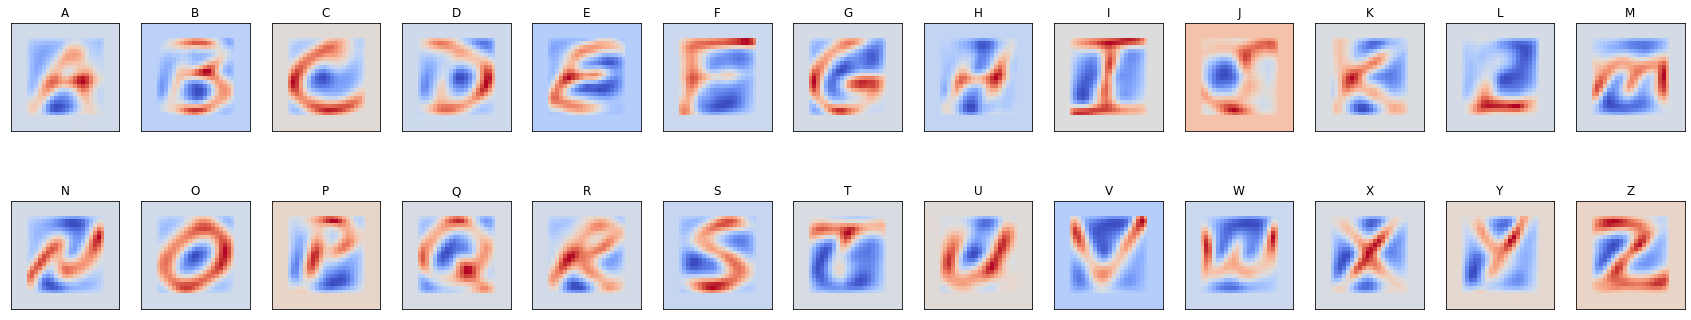

In [13]:
plt.figure(figsize=(30, 6))

for i in range(26):
    plt.subplot(2, 13, i+1)
    plt.imshow(nn.Layers[0].W[i, :].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
    plt.title(chr(65+i))
plt.show()

The model `nn_v2` below illustrates how much using an activation function such as _softmax_ and choosing the proper loss function can affect the training process and how good the model performs compared to the previous ones:

In [14]:
nn_v2 = NeuralNetwork([
    
    Layer(784, 26, Activation="soft")
                    ],
    softmax_cross_entropy_cost,
    dsoftmax_cross_entropy_cost,
    num_iterations=100,
    alpha=.009
)
nn_v2.fit(X_train, y_train, X_val, y_val, batch_size=64)

Iteration   1: training loss = 2.79 | validation loss = 2.40
Iteration   2: training loss = 2.14 | validation loss = 1.92
Iteration   3: training loss = 1.76 | validation loss = 1.63
Iteration   4: training loss = 1.54 | validation loss = 1.45
Iteration   5: training loss = 1.38 | validation loss = 1.32
Iteration   6: training loss = 1.28 | validation loss = 1.22
Iteration   7: training loss = 1.20 | validation loss = 1.15
Iteration   8: training loss = 1.12 | validation loss = 1.09
Iteration   9: training loss = 1.07 | validation loss = 1.05
Iteration  10: training loss = 1.04 | validation loss = 1.01
Iteration  11: training loss = 1.01 | validation loss = 0.98
Iteration  12: training loss = 0.98 | validation loss = 0.95
Iteration  13: training loss = 0.94 | validation loss = 0.93
Iteration  14: training loss = 0.92 | validation loss = 0.91
Iteration  15: training loss = 0.91 | validation loss = 0.89
Iteration  16: training loss = 0.89 | validation loss = 0.87
Iteration  17: training 

In [15]:
train_acc = accuracy(nn_v2.predict(X_train), y_train)
valid_acc = accuracy(nn_v2.predict(X_val), y_val)
test_acc = accuracy(nn_v2.predict(X_test), y_test)


print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))
print('Testing accuracy = {:.2f}%'.format(test_acc))

Training accuracy =   85.47%
Validation accuracy = 83.98%
Testing accuracy = 83.48%


Better Accuracy!

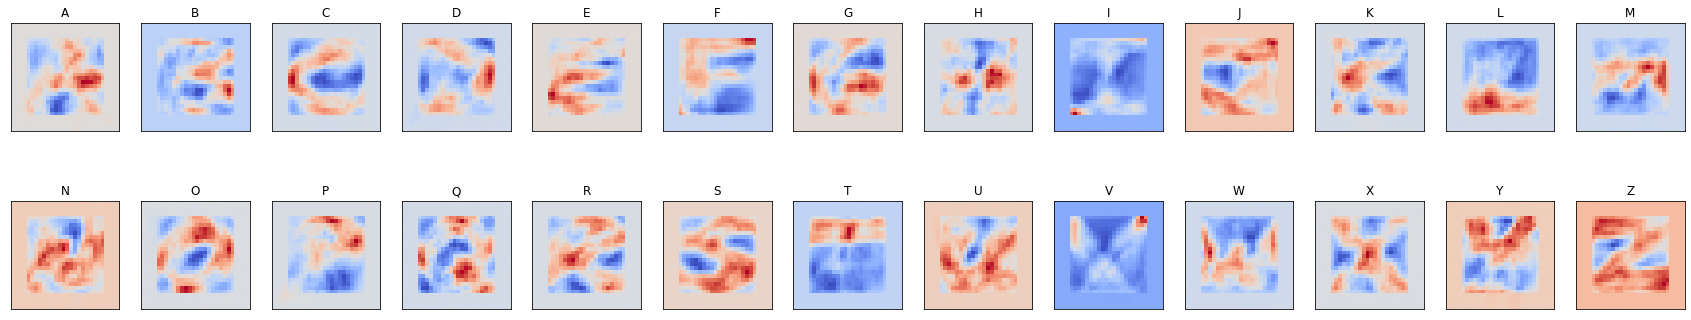

In [16]:
plt.figure(figsize=(30, 6))

for i in range(26):
    plt.subplot(2, 13, i+1)
    plt.imshow(nn_v2.Layers[0].W[i, :].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
    plt.title(chr(65+i))
plt.show()

Less overfitting!